In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers.core import Dropout, Dense
from keras.layers import Input, TimeDistributed, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_lr_finder import LRFinder

In [11]:
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'
PATH_EMBED = '../../'

In [12]:
train = pd.read_csv(PATH_DATA+'CRC_3200_train.csv')
test = pd.read_csv(PATH_DATA+'CRC_800_test.csv')

In [116]:
# training set
X_train = np.array(train.text_review)
y_train = to_categorical(train.bin_tag)

# test set
X_test = np.array(test.text_review)
y_test = to_categorical(test.bin_tag)

Determining the maximum length of inputs.

In [117]:
print(train.num_tokens.describe(percentiles=[.25, .5, .75, .9, .99]))

count    3200.000000
mean       62.586250
std       118.035125
min         1.000000
25%        13.000000
50%        29.000000
75%        66.000000
90%       136.000000
99%       523.010000
max      2865.000000
Name: num_tokens, dtype: float64


150 seems like a good value

In [118]:
MAXLEN = 150

tokenizer = Tokenizer(num_words=20000, filters='', lower=True, char_level=False)

tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

VOCAB_SIZE = len(tokenizer.word_index) + 1

X_train_final = pad_sequences(X_train_tok, maxlen=MAXLEN, padding='post', truncating='post')
X_test_final = pad_sequences(X_test_tok, maxlen=MAXLEN, padding='post', truncating='post')

## Loading and mapping GloVe embeddings

In [16]:
glove = PATH_EMBED + 'glove.twitter.27B.200d.txt'

def load_words(embd_filepath):
    embd_dict = dict()
    with open(embd_filepath, encoding="utf8") as emb_file:
        for line in islice(emb_file, 1, None):
            records = line.split(' ')
            word = records[0]
            vector = np.asarray(records[1:], dtype='float32')            
            embd_dict[word] = vector
    return embd_dict

embd_dict = load_words(glove)

In [119]:
word_embedding = np.zeros((VOCAB_SIZE, 200))

for word, index in tokenizer.word_index.items():
    embedding_vector = embd_dict.get(word)
    if embedding_vector is not None:
        word_embedding[index] = embedding_vector

## Model building

In [105]:
def make_model(vocab_size, maxlen, embeddings):
    
    #input
    input_layer = Input(shape=(None,), name='Input')
    
    #embedding
    embedding_layer = Embedding(vocab_size, 200, weights=[embeddings],
                            input_length=maxlen, trainable=False)(input_layer)
    
    #LSTM
    rnn_layer = Bidirectional(LSTM(128))(embedding_layer)
    
    #dropout
    dropout_layer = Dropout(0.3)(rnn_layer)
    
    
    #softmax
    output_layer = Dense(2, activation='softmax')(dropout_layer)
    
    return Model(inputs=input_layer, outputs=output_layer)

In [106]:
model = make_model(VOCAB_SIZE, MAXLEN, word_embedding)

In [114]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              weighted_metrics=['categorical_accuracy'],
             )

In [115]:
lr_finder = LRFinder(model)
lr_finder.find(X_train_final, y_train, 0.00001, 1, 1, 3)

Epoch 1/3
 228/3200 [=>............................] - ETA: 7:04 - loss: 1.4200 - categorical_accuracy: 0.3289

KeyboardInterrupt: 

In [ ]:
lr_finder.plot_loss()

In [102]:
hyperparameters = {
    'lr': 0.00001,
    'epochs': 20,
    'batch_size': 32,
    'validation_size': 0.1,
}

In [103]:
#early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)

#model checkpoints
checkpoints = ModelCheckpoint(PATH_MODELS+'best.cnn1-lstm1.weights.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

#class weights
weights = class_weight.compute_class_weight('balanced', np.unique(test.tag), test.tag)
class_weights = dict(enumerate(weights))

In [104]:
history = model.fit(X_train_final,
                    y_train, 
                    batch_size=hyperparameters['batch_size'],
                    epochs=hyperparameters['epochs'],
                    validation_split=hyperparameters['validation_size'],
                    callbacks=[early_stop, checkpoints],
                    class_weight=class_weights,
                    verbose=1,
                   )

Train on 2880 samples, validate on 320 samples
Epoch 1/20
2880/2880 [==============================] - 8s 3ms/step - loss: 0.2424 - categorical_accuracy: 0.9134 - val_loss: 1.0969 - val_categorical_accuracy: 0.6685

Epoch 00001: val_loss improved from inf to 1.09690, saving model to ../../models/best.cnn1-lstm1.weights.hdf5
Epoch 2/20
2880/2880 [==============================] - 7s 3ms/step - loss: 0.1733 - categorical_accuracy: 0.9418 - val_loss: 1.0957 - val_categorical_accuracy: 0.6773

Epoch 00002: val_loss improved from 1.09690 to 1.09573, saving model to ../../models/best.cnn1-lstm1.weights.hdf5
Epoch 3/20
2880/2880 [==============================] - 7s 3ms/step - loss: 0.1363 - categorical_accuracy: 0.9571 - val_loss: 1.2789 - val_categorical_accuracy: 0.6470

Epoch 00003: val_loss did not improve from 1.09573
Epoch 4/20
1856/2880 [==================>...........] - ETA: 2s - loss: 0.1063 - categorical_accuracy: 0.9635

KeyboardInterrupt: 

## Ploting

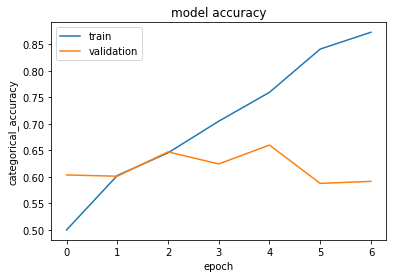

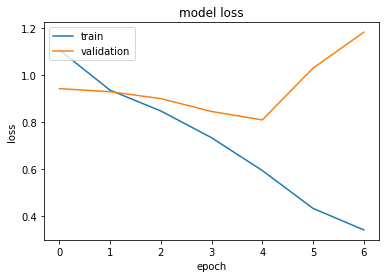

In [101]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

## Testing

Accuracy: 0.58875
F1 Score: 0.6018129106875134
              precision    recall  f1-score   support

           0       0.32      0.69      0.43       108
           1       0.63      0.55      0.59       280
           2       0.83      0.51      0.63       300
           3       0.66      0.81      0.73       112

    accuracy                           0.59       800
   macro avg       0.61      0.64      0.59       800
weighted avg       0.67      0.59      0.60       800



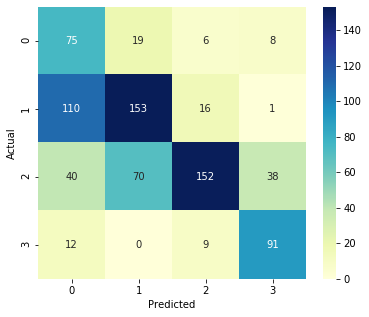

In [91]:
y_pred = model.predict(X_test_final)
y_gold = [np.argmax(i) for i in y_test]
y_scores = [np.argmax(i) for i in y_pred]

print("Accuracy:", accuracy_score(y_gold, y_scores))
print("F1 Score:", f1_score(y_gold, y_scores, average='weighted'))
print(classification_report(y_gold, y_scores))

conf_mat = confusion_matrix(y_gold, y_scores)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [110]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, None)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 150, 200)          3027600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 1028      
Total params: 3,365,524
Trainable params: 337,924
Non-trainable params: 3,027,600
_________________________________________________________________
